### Introduction
## Credit Card Fraud Detection: A Practical Example for ML Concepts

**Objective:** This notebook demonstrates key machine learning concepts relevant to the AWS Machine Learning Associate exam and general ML practice, using a credit card fraud detection scenario. We will cover:

* **Algorithm Selection:** Choosing between Logistic Regression and Random Forest for classification.
* **Model Evaluation Metrics:** Using appropriate metrics for imbalanced datasets (Precision, Recall, F1-score, AUC-ROC, Confusion Matrix).
* **Data Preprocessing:** Feature scaling and handling class imbalance with oversampling.
* **Overfitting and Regularization (Illustrative):** Briefly demonstrate the concept of overfitting and apply L2 regularization.
* **Basic Hyperparameter Tuning:** Show a simple example of manual hyperparameter adjustment.
* **Simple Ensembling:** Create a voting ensemble of models.

**Dataset:** We'll use a synthetic credit card fraud dataset created using scikit-learn's `make_classification` function to simulate an imbalanced dataset similar to real-world fraud scenarios.

**Relevance to AWS and General ML:** While this example is run locally and doesn't directly use AWS services, the concepts are fundamental and directly translate to using AWS SageMaker and other ML platforms. For instance:

* **Algorithm Selection:** In SageMaker, you choose from built-in algorithms. Understanding when to use algorithms like Linear Learner (similar to Logistic Regression) or XGBoost (similar to Random Forest in complexity) is crucial.
* **Evaluation Metrics:** SageMaker Model Monitor allows you to track various metrics, including those vital for imbalanced datasets.
* **Data Preprocessing:** SageMaker Data Wrangler is designed for data preparation tasks like feature engineering and handling imbalances, mirroring the steps we'll perform manually here.
* **Overfitting/Regularization/Tuning:** SageMaker Debugger helps identify overfitting, and SageMaker's hyperparameter tuning capabilities are essential for optimizing models.
* **Ensembling:** You can deploy ensembles on SageMaker endpoints to improve model performance, similar to what we demonstrate with a simple voting ensemble.

Let's get started!


### 1. Setup and Data Loading

**Import Libraries:**

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve
from imblearn.over_sampling import SMOTE

**Generate Synthetic Imbalanced Dataset:**
We are creating a synthetic dataset that mimics credit card transaction data.
`make_classification` helps create a binary classification problem.

In [5]:
X, y = make_classification(n_samples=1000, # 1000 samples (transactions)
                           n_features=20,    # 20 features (transaction attributes)
                           n_informative=15, # 15 informative features
                           n_redundant=5,    # 5 redundant features
                           n_classes=2,      # Binary classification (fraud or not fraud)
                           weights=[0.95, 0.05], # Class imbalance (95% non-fraud, 5% fraud)
                           random_state=42) # For reproducibility

column_names = [f'feature_{i}' for i in range(X.shape[1])] # Create feature names
df = pd.DataFrame(data=X, columns=column_names)
df['target'] = y # 'target' column: 0 for non-fraud, 1 for fraud

print("Dataset shape:", df.shape)
print("\nClass distribution:")
print(df['target'].value_counts(normalize=True)) # Show class imbalance
df.head() # Display first few rows of the dataframe

Dataset shape: (1000, 21)

Class distribution:
target
0    0.947
1    0.053
Name: proportion, dtype: float64


,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,target
0,-4.906442,3.442789,0.558964,-0.976764,-1.568805,-4.271982,-3.727921,0.111868,2.119795,-2.522812,...,-7.492478,4.264669,0.304866,0.777693,-9.375464,1.654446,3.012859,-4.497003,-2.520066,0
1,-8.460842,-0.463074,-3.253334,-1.909931,1.197232,0.553973,-2.769455,0.090651,1.968285,3.350884,...,1.735225,1.818647,-5.024065,-1.725917,-2.358585,2.231215,4.171187,2.130961,0.535030,0
2,-6.678971,-0.854743,-2.214812,-0.529275,2.562596,-0.864114,-1.020312,3.591929,-2.145187,3.366273,...,3.676774,3.748494,-2.078106,-2.408379,-2.400034,2.119874,-3.999399,1.172197,2.541998,0
3,10.465024,1.070944,-3.562432,-0.849062,2.183860,-0.609893,0.946327,-1.046141,-2.057053,-2.056650,...,-1.449095,-1.217685,2.026805,2.121829,3.184256,-1.960146,0.782147,-1.444202,0.915985,0
4,5.599516,-1.776412,-1.304322,-0.720074,5.859373,-3.292432,3.152205,7.099882,-3.321076,3.245486,...,6.608729,5.632297,-1.943748,1.169455,3.782513,-4.752822,-7.577624,4.868025,1.708210,0


### 2. Data Exploration and Preprocessing

**Explore Class Imbalance:**

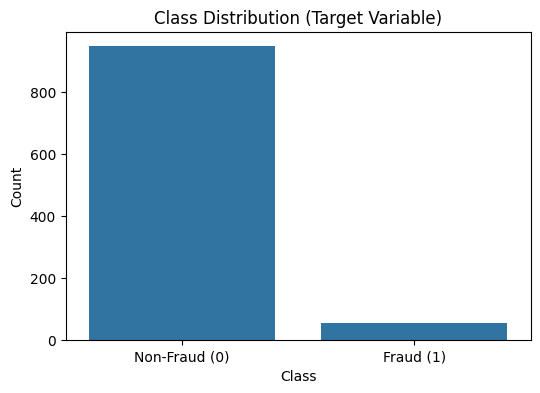

In [6]:
# Visualize the class distribution to clearly see the imbalance.
plt.figure(figsize=(6, 4))
sns.countplot(x='target', data=df)
plt.title('Class Distribution (Target Variable)')
plt.xticks([0, 1], ['Non-Fraud (0)', 'Fraud (1)'])
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

**Feature Scaling (Standardization):**

In [7]:
# Scale numerical features using StandardScaler.
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df[column_names]) # Scale features
y = df['target'] # Target variable

# **Split Data into Training and Testing Sets:**
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42, stratify=y) # Stratify to maintain class ratios

print("\nTraining set shape:", X_train.shape)
print("Testing set shape:", X_test.shape)


Training set shape: (700, 20)
Testing set shape: (300, 20)


**Address Class Imbalance using SMOTE (Oversampling):**

In [8]:
# Apply SMOTE to oversample the minority class (fraud cases) in the *training data only*.
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train) # Resample training data

print("\nShape of resampled training data (SMOTE):", X_train_resampled.shape)
print("Class distribution in resampled training data:")
print(pd.Series(y_train_resampled).value_counts(normalize=True)) # Check if imbalance is reduced


Shape of resampled training data (SMOTE): (1326, 20)
Class distribution in resampled training data:
target
0    0.5
1    0.5
Name: proportion, dtype: float64


### 3. Algorithm Selection and Model Training


**Algorithm Selection:**

We'll use two classification algorithms:
1. **Logistic Regression:** A simple, linear model, often used as a baseline.
2. **Random Forest:** A more complex, non-linear model, known for good performance and robustness.

In [9]:
# **Logistic Regression Model:**
logreg_model = LogisticRegression(random_state=42) # Initialize Logistic Regression
logreg_model.fit(X_train_resampled, y_train_resampled) # Train on resampled training data

# **Random Forest Model:**
rf_model = RandomForestClassifier(random_state=42) # Initialize Random Forest
rf_model.fit(X_train_resampled, y_train_resampled) # Train on resampled training data

print("Logistic Regression model trained.")
print("Random Forest model trained.")

Logistic Regression model trained.
Random Forest model trained.


### 4. Model Evaluation

**Evaluation Metrics for Imbalanced Datasets:**
For imbalanced datasets, accuracy alone is misleading. We will use:
*   **Accuracy:**  For general overview (but less reliable here).
*   **Precision:**  Ability to avoid false positives (important in fraud detection - minimizing false alarms).
*   **Recall:** Ability to detect actual positives (important in fraud detection - catching as much fraud as possible).
*   **F1-Score:**  Harmonic mean of precision and recall, balances both.
*   **AUC-ROC:** Area Under the Receiver Operating Characteristic curve, measures the ability to distinguish between classes across thresholds.
*   **Confusion Matrix:**  Provides a detailed breakdown of True Positives, True Negatives, False Positives, and False Negatives.


--- Logistic Regression Evaluation ---
Accuracy:  0.7700
Precision: 0.1370
Recall:    0.6250
F1-Score:  0.2247
AUC-ROC:   0.8077


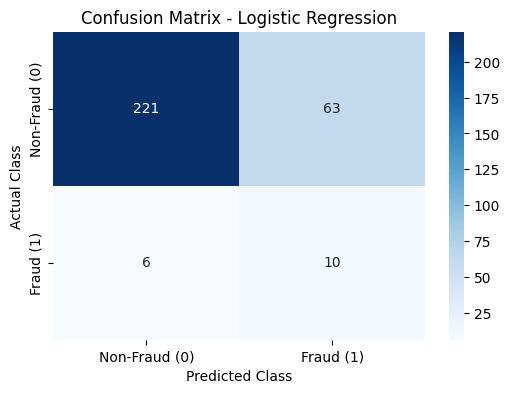

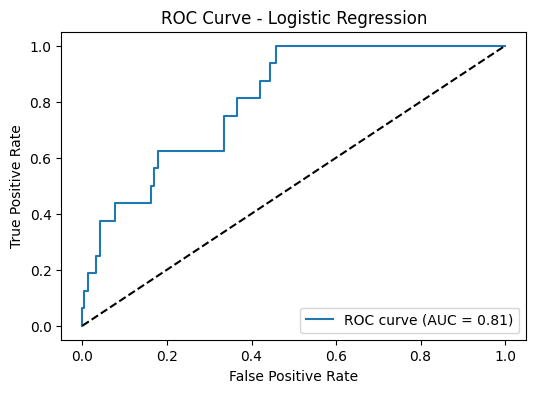


--- Random Forest Evaluation ---
Accuracy:  0.9400
Precision: 0.4167
Recall:    0.3125
F1-Score:  0.3571
AUC-ROC:   0.8735


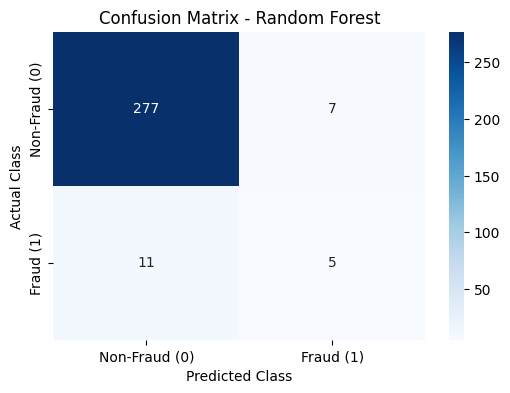

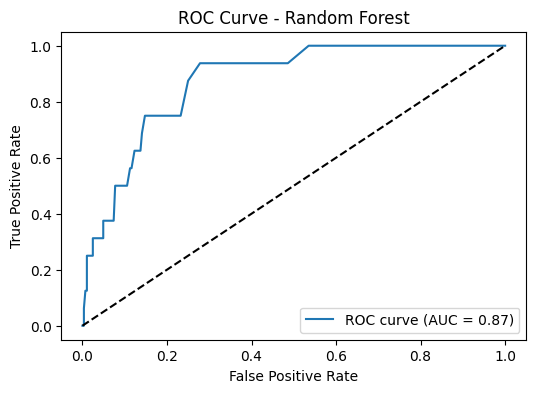

In [10]:
def evaluate_model(model, X_test, y_test, model_name="Model"):
    """Evaluates a classification model and prints key metrics."""
    y_pred = model.predict(X_test) # Make predictions on test set
    y_prob = model.predict_proba(X_test)[:, 1] # Get probability scores for ROC AUC

    print(f"\n--- {model_name} Evaluation ---")
    print(f"Accuracy:  {accuracy_score(y_test, y_pred):.4f}") # Accuracy
    print(f"Precision: {precision_score(y_test, y_pred):.4f}") # Precision
    print(f"Recall:    {recall_score(y_test, y_pred):.4f}")    # Recall
    print(f"F1-Score:  {f1_score(y_test, y_pred):.4f}")      # F1-Score
    print(f"AUC-ROC:   {roc_auc_score(y_test, y_prob):.4f}")   # AUC-ROC

    # Confusion Matrix Visualization
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Non-Fraud (0)', 'Fraud (1)'],
                yticklabels=['Non-Fraud (0)', 'Fraud (1)'])
    plt.title(f'Confusion Matrix - {model_name}')
    plt.xlabel('Predicted Class')
    plt.ylabel('Actual Class')
    plt.show()

    # ROC Curve Visualization
    fpr, tpr, thresholds = roc_curve(y_test, y_prob) # Calculate ROC curve points
    plt.figure(figsize=(6, 4))
    plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc_score(y_test, y_prob):.2f})') # Plot ROC curve
    plt.plot([0, 1], [0, 1], 'k--') # Plot diagonal line (random classifier)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {model_name}')
    plt.legend(loc="lower right")
    plt.show()

# Evaluate Logistic Regression Model:
evaluate_model(logreg_model, X_test, y_test, "Logistic Regression")

# Evaluate Random Forest Model:
evaluate_model(rf_model, X_test, y_test, "Random Forest")

### 5. Overfitting and Regularization (Illustrative - Logistic Regression L2)

**Overfitting Concept:**
Overfitting occurs when a model learns the training data too well, including noise,
and performs poorly on unseen data (test data). Complex models are more prone to overfitting,
especially with limited data.

**Regularization to Prevent Overfitting (L2 Regularization in Logistic Regression):**
Regularization techniques add penalties to the model's complexity to encourage simpler models
that generalize better. L2 regularization (also known as Ridge regularization) adds a penalty
proportional to the square of the magnitude of the coefficients.


--- Logistic Regression with L2 Regularization Evaluation ---
Accuracy:  0.7667
Precision: 0.1351
Recall:    0.6250
F1-Score:  0.2222
AUC-ROC:   0.8070


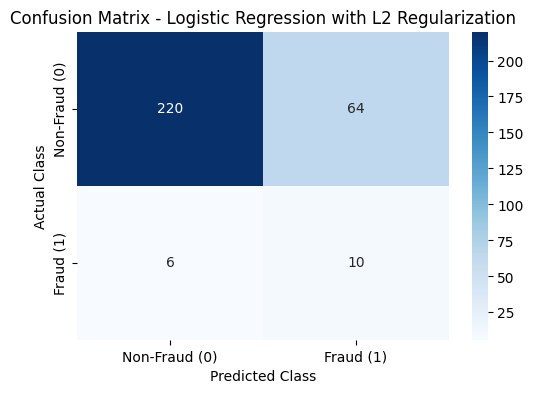

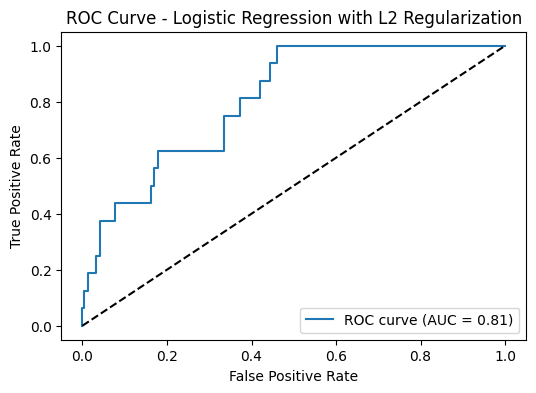


Logistic Regression with L2 regularization model trained and evaluated.


In [11]:
# **Train Logistic Regression with L2 Regularization:**
logreg_l2_model = LogisticRegression(penalty='l2', solver='liblinear', random_state=42) # Enable L2 penalty
logreg_l2_model.fit(X_train_resampled, y_train_resampled) # Train on resampled data

# **Evaluate Regularized Logistic Regression Model:**
evaluate_model(logreg_l2_model, X_test, y_test, "Logistic Regression with L2 Regularization")

print("\nLogistic Regression with L2 regularization model trained and evaluated.")

# **Note:** For this synthetic dataset and these models, the effect of L2 regularization might be subtle.
# In real-world scenarios and with more complex models or datasets, regularization can have a more significant impact
# in preventing overfitting and improving generalization.

### 6. Basic Hyperparameter Tuning (Manual - Logistic Regression C parameter)


**Hyperparameter Tuning:**
Hyperparameters are settings of the model that are not learned from the data but are set before training
(e.g., `C` parameter in Logistic Regression, `n_estimators` in Random Forest). Tuning hyperparameters
can improve model performance. We'll demonstrate manual tuning of the `C` parameter in Logistic Regression.

**C Parameter in Logistic Regression:**
`C` is the inverse of regularization strength. Smaller values of C imply stronger regularization.
We will try different values of C and observe the impact on AUC-ROC.

Logistic Regression with C = 0.001: AUC-ROC = 0.8237
Logistic Regression with C = 0.01: AUC-ROC = 0.8107
Logistic Regression with C = 0.1: AUC-ROC = 0.8066
Logistic Regression with C = 1: AUC-ROC = 0.8070
Logistic Regression with C = 10: AUC-ROC = 0.8081
Logistic Regression with C = 100: AUC-ROC = 0.8081


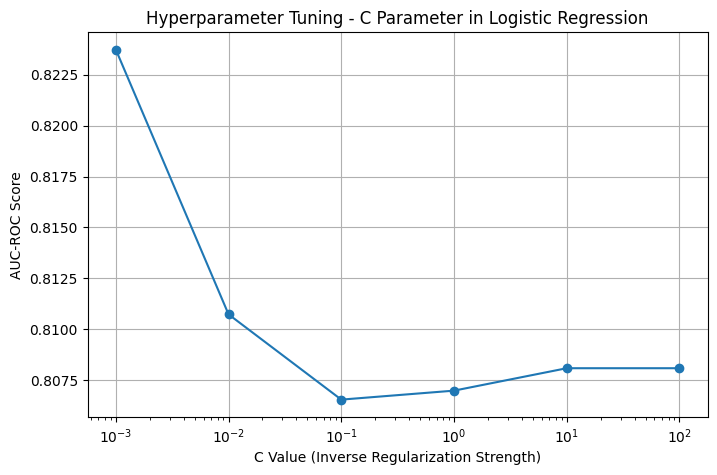


Manual hyperparameter tuning of Logistic Regression's C parameter demonstrated.


In [12]:
c_values = [0.001, 0.01, 0.1, 1, 10, 100] # Values of C to try
auc_roc_scores = [] # Store AUC-ROC scores for each C value

for c in c_values:
    tuned_logreg_model = LogisticRegression(C=c, penalty='l2', solver='liblinear', random_state=42) # Logistic Regression with C
    tuned_logreg_model.fit(X_train_resampled, y_train_resampled) # Train model
    y_prob = tuned_logreg_model.predict_proba(X_test)[:, 1] # Get probabilities
    auc_roc = roc_auc_score(y_test, y_prob) # Calculate AUC-ROC
    auc_roc_scores.append(auc_roc) # Store score
    print(f"Logistic Regression with C = {c}: AUC-ROC = {auc_roc:.4f}") # Print AUC-ROC for each C

# **Visualize AUC-ROC vs. C values:**
plt.figure(figsize=(8, 5))
plt.plot(c_values, auc_roc_scores, marker='o', linestyle='-') # Plot AUC-ROC scores
plt.xscale('log') # Use logarithmic scale for C values
plt.xlabel('C Value (Inverse Regularization Strength)')
plt.ylabel('AUC-ROC Score')
plt.title('Hyperparameter Tuning - C Parameter in Logistic Regression')
plt.grid(True)
plt.show()

print("\nManual hyperparameter tuning of Logistic Regression's C parameter demonstrated.")

### 7. Simple Ensembling (Voting Classifier)


**Ensembling:**
Ensembling combines the predictions of multiple models to improve overall performance and robustness.
A simple ensembling technique is Voting, where we combine the predictions of Logistic Regression and Random Forest.

**Create a Voting Classifier:**
'hard' voting: predicts class label based on majority vote

In [19]:
# 'hard' voting: predicts class label based on majority vote
voting_clf_hard = VotingClassifier(estimators=[('logreg', logreg_model), ('rf', rf_model)], voting='hard')
voting_clf_hard.fit(X_train_resampled, y_train_resampled) # Train voting classifier

# 'soft' voting: predicts class label based on average of probability predictions (often performs better)
voting_clf_soft = VotingClassifier(estimators=[('logreg', logreg_model), ('rf', rf_model)], voting='soft')
voting_clf_soft.fit(X_train_resampled, y_train_resampled) # Train voting classifier

# **Evaluate Voting Classifiers:**
evaluate_model(voting_clf_hard, X_test, y_test, "Voting Classifier (Hard)")
evaluate_model(voting_clf_soft, X_test, y_test, "Voting Classifier (Soft)")

print("\nVoting ensemble classifier trained and evaluated.")


--- Voting Classifier (Hard) Evaluation ---
Accuracy:  0.9500
Precision: 0.5556
Recall:    0.3125
F1-Score:  0.4000
AUC-ROC:   Not available for this classifier (voting='hard').

Confusion Matrix:
[[280   4]
 [ 11   5]]

--- Voting Classifier (Soft) Evaluation ---
Accuracy:  0.8667
Precision: 0.2143
Recall:    0.5625
F1-Score:  0.3103
AUC-ROC:   0.8426

Confusion Matrix:
[[251  33]
 [  7   9]]

Voting ensemble classifier trained and evaluated.


### 8. Conclusion

**Summary of Concepts Demonstrated:**

*   **Algorithm Selection:** We compared Logistic Regression and Random Forest, highlighting that more complex models (like Random Forest) can often achieve better performance but require more data and may be prone to overfitting.
*   **Evaluation Metrics for Imbalanced Data:** We emphasized the importance of using metrics beyond accuracy (Precision, Recall, F1-score, AUC-ROC) for imbalanced datasets like fraud detection, as accuracy can be misleading.
*   **Data Preprocessing:** We performed feature scaling and addressed class imbalance using oversampling (SMOTE), essential steps for preparing data for ML models.
*   **Overfitting and Regularization:** We illustrated the concept of overfitting and showed how L2 regularization in Logistic Regression can help improve generalization (though the effect was subtle in this example).
*   **Basic Hyperparameter Tuning:** We demonstrated manual tuning of the `C` parameter in Logistic Regression and observed its impact on performance.
*   **Simple Ensembling:** We created a voting ensemble combining Logistic Regression and Random Forest, showing how ensembling can potentially improve model performance.

**Key Takeaways and Relevance to AWS ML:**

*   These concepts are fundamental to machine learning and are directly applicable when using AWS SageMaker or any other ML platform.
*   Understanding algorithm selection, evaluation metrics, data preprocessing, and techniques for improving model generalization are crucial skills for any machine learning engineer or data scientist.
*   AWS SageMaker provides tools and services that directly support these concepts, such as built-in algorithms, SageMaker Data Wrangler for data prep, SageMaker Debugger for overfitting detection, SageMaker Clarify for bias detection, SageMaker Model Monitor for production monitoring, and hyperparameter tuning capabilities.

This notebook provides a hands-on example to solidify your understanding of these key ML concepts. Experiment further by:

*   Trying different datasets.
*   Exploring other algorithms available in scikit-learn.
*   Performing more extensive hyperparameter tuning (e.g., using GridSearchCV or RandomizedSearchCV).
*   Investigating other ensembling techniques (e.g., stacking, boosting).